In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
! kaggle competitions download -c twitter-sentiment-analysis2

  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 120MB/s]
 46% 5.00M/11.0M [00:00<00:00, 33.5MB/s]
100% 11.0M/11.0M [00:00<00:00, 53.7MB/s]


In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
import seaborn as sns

In [ ]:
# import the data 
data = pd.read_csv("train.csv.zip",encoding = "ISO-8859-1",index_col = 0)

In [0]:
data.head()

,Sentiment,SentimentText
ItemID,,
1,0,is so sad for my APL frie...
2,0,I missed the New Moon trail...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I'...
5,0,i think mi bf is cheating on me!!! ...


In [0]:
# count the size of the classes
print("Sad",(data.Sentiment == 0).sum())
print("Neutral",(data.Sentiment == 1).sum())

Sad 43532
Neutral 56457


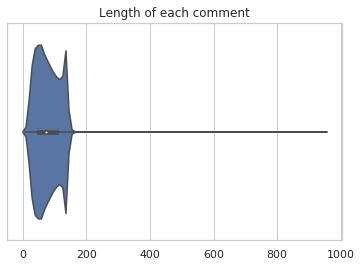

In [0]:
# plot the lenght of the comments
sns.set(style="whitegrid")
ax = sns.violinplot(x=[len(t) for t in data['SentimentText']],scale='width').set_title('Length of each comment')

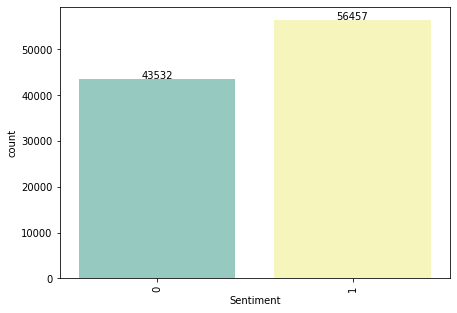

In [0]:
# histogramm of the size of the two classes
fig, ax1 = plt.subplots(figsize=(7,5))
graph = sns.countplot(ax=ax1,x='Sentiment', data=data,palette='Set3')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        data['Sentiment'].value_counts()[i],ha="center")
    i += 1

In [0]:
# tokenize which removes handles(@name) reduces the lenght of repetitive letters and lower case the comments
tknzr = TweetTokenizer(strip_handles=True,reduce_len=True,preserve_case = False)
data["tokenized"] = [tknzr.tokenize(data.iloc[i].SentimentText) for i in range(len(data))]
# stitch the tokens back to sentenses
data["tokenized"] = [" ".join(data.tokenized.iloc[i]) for i in range(len(data))]

In [0]:
# split the dataset into train and test set in ratio 9/1
x_train, x_test, y_train, y_test = train_test_split(data.tokenized, data.Sentiment, test_size=0.1, random_state=8888)

In [0]:
# take the tf id frequency for the comments in order to feed the models
nltk.download('stopwords')
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True, min_df=3, stop_words=stopwords.words('english'))

x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# use the majority model as a classifier. It assigns all the comments in the most frequent class.
base = DummyClassifier(strategy='most_frequent')
# train dummy classifier
base.fit(x_train_tfidf, y_train)
# predict 
predictions = base.predict(x_train_tfidf)
print("Classification report for classifier %s:\n%s\n"%(base, metrics.classification_report(y_train, predictions)))

Classification report for classifier DummyClassifier(constant=None, random_state=None, strategy='most_frequent'):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     39169
           1       0.56      1.00      0.72     50821

    accuracy                           0.56     89990
   macro avg       0.28      0.50      0.36     89990
weighted avg       0.32      0.56      0.41     89990




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# train and predict the logistic model with random hyperparameters
clf = LogisticRegression(solver="liblinear",random_state=8888)
# fit logistic regression
clf.fit(x_train_tfidf, y_train)
# predict logistic regression
predictions = clf.predict(x_train_tfidf)
print("Classification report for classifier %s:\n%s\n"%(clf, metrics.classification_report(y_train, predictions)))

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8888, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.68      0.73     39169
           1       0.78      0.85      0.81     50821

    accuracy                           0.77     89990
   macro avg       0.77      0.76      0.77     89990
weighted avg       0.77      0.77      0.77     89990




In [0]:
# train and predict the KNN model with random hyperparameters
clf = KNeighborsClassifier(n_neighbors=5)
# fit KNN
clf.fit(x_train_tfidf, y_train)
# predict KNN
predictions = clf.predict(x_train_tfidf)
print("Classification report for classifier %s:\n%s\n"%(clf, metrics.classification_report(y_train, predictions)))

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'):
              precision    recall  f1-score   support

           0       0.76      0.65      0.70     39169
           1       0.75      0.84      0.79     50821

    accuracy                           0.76     89990
   macro avg       0.76      0.74      0.75     89990
weighted avg       0.76      0.76      0.75     89990




In [0]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

In [0]:
# Grid search for logistic regression
grid_params = {
  'lr__solver': ['liblinear'],
  'lr__C': [0.001,0.01,0.1,1,10,100],
  'lr__random_state': [8888],
  'tfidf_vectorizer__min_df': [3,4,5],
  'tfidf_vectorizer__max_features':[2500,5000,10000],
  'tfidf_vectorizer__ngram_range': [(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],  
}

clf = GridSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.8063859933414946
Best Params:  {'lr__C': 1, 'lr__random_state': 8888, 'lr__solver': 'liblinear', 'tfidf_vectorizer__max_features': 10000, 'tfidf_vectorizer__min_df': 5, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__sublinear_tf': True}


In [0]:
# use the hyperparameters which performed best in the grid search , train and predict the logistic regression
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 10000, sublinear_tf=True, min_df=5, stop_words=stopwords.words('english'))

x_train_tfidf_logistic = vectorizer.fit_transform(x_train)
x_test_tfidf_logistic = vectorizer.transform(x_test)

clf_logistic = LogisticRegression(solver="liblinear",random_state=8888,C=1)
# train the logistic regression
clf_logistic.fit(x_train_tfidf_logistic, y_train)
# predict in train set
predictions = clf_logistic.predict(x_train_tfidf_logistic)
print("Classification report for classifier in train %s:\n%s\n"%(clf_logistic, metrics.classification_report(y_train, predictions)))
# predict for the test set
predictions_test_logistic = clf_logistic.predict(x_test_tfidf_logistic)
print("Classification report for classifier in test %s:\n%s\n"%(clf_logistic, metrics.classification_report(y_test, predictions_test_logistic)))

Classification report for classifier in train LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8888, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       0.79      0.70      0.74     39169
           1       0.79      0.86      0.82     50821

    accuracy                           0.79     89990
   macro avg       0.79      0.78      0.78     89990
weighted avg       0.79      0.79      0.79     89990


Classification report for classifier in test LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8888, solv

In [0]:
# A custom function that plots the learning curves of a model 
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

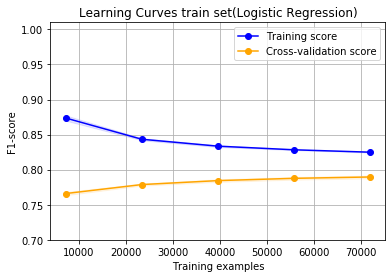

In [0]:
X, y = x_train_tfidf_logistic,y_train

title = "Learning Curves train set(Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression(C=1,solver="liblinear",random_state=8888)
# plot the learning curve fro logistic regression
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()


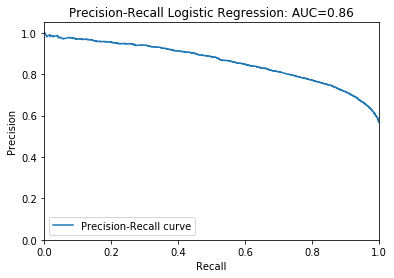

In [0]:
estimator = LogisticRegression(C=1,solver="liblinear",random_state=8888)
name = 'Logistic Regression'
model =estimator
model.fit(x_train_tfidf_logistic,y_train)
pred = model.predict_proba(x_test_tfidf_logistic)
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
area = auc(recall, precision)

# plot the AUC curve for logistic regression 
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' %(name,area))
plt.legend(loc="lower left")
plt.show()

In [0]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('kn', KNeighborsClassifier())])

In [0]:
# grid search for KNN 
grid_params = {
  'kn__n_neighbors': [2,3,4,5],
  'tfidf_vectorizer__min_df': [3,4,5],
  'tfidf_vectorizer__max_features':[2500,5000,10000],
  'tfidf_vectorizer__ngram_range': [(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],  
}

clf = RandomizedSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3, n_iter=100)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.7045160480949003
Best Params:  {'tfidf_vectorizer__sublinear_tf': False, 'tfidf_vectorizer__ngram_range': (1, 3), 'tfidf_vectorizer__min_df': 3, 'tfidf_vectorizer__max_features': 2500, 'kn__n_neighbors': 5}


In [0]:
# Use the hyperparameters from grid search train and predict the KNN model
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features = 2500, sublinear_tf=False, min_df=3, stop_words=stopwords.words('english'))

x_train_tfidf_knn = vectorizer.fit_transform(x_train)
x_test_tfidf_knn = vectorizer.transform(x_test)

clf_knn = KNeighborsClassifier(n_neighbors=5)
# Train KNN
clf_knn.fit(x_train_tfidf_knn, y_train)
#Predict in train set 
predictions = clf_knn.predict(x_train_tfidf_knn)
print("Classification report for classifier in train%s:\n%s\n"%(clf_knn, metrics.classification_report(y_train, predictions)))
# Predict in test set
predictions_test_knn = clf_knn.predict(x_test_tfidf_knn)
print("Classification report for classifier in test %s:\n%s\n"%(clf_knn, metrics.classification_report(y_test, predictions_test_knn)))

Classification report for classifier in trainKNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'):
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     39169
           1       0.75      0.85      0.80     50821

    accuracy                           0.75     89990
   macro avg       0.76      0.74      0.74     89990
weighted avg       0.76      0.75      0.75     89990


Classification report for classifier in test KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'):
              precision    recall  f1-score   support

           0       0.61      0.49      0.54      4363
           1       0.66      0.76      0.70      5636

    accuracy                           0.6

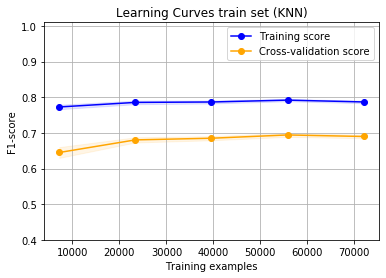

In [0]:
X, y = x_train_tfidf_knn,y_train

title = "Learning Curves train set (KNN)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier(n_neighbors=5)
# plot the learning curves for KNN
plot_learning_curve(estimator, title, X, y, (0.4, 1.01), cv=cv)
plt.show()

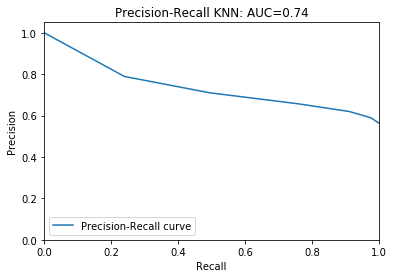

In [0]:
name = "KNN"
estimator = KNeighborsClassifier(n_neighbors=5)
model =estimator
model.fit(x_train_tfidf_knn,y_train)
pred = model.predict_proba(x_test_tfidf_knn)
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
area = auc(recall, precision)

# Plot the Area Under Curve for KNN model
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
plt.legend(loc="lower left")
plt.show()

In [0]:
# H0 logistic regression perfoms as good as KNN : F1_logistic = F1_KNN
# H1 Logistic regression performs better than KNN : F1_logistic > F1_KNN

# n: lenght of test set
n = x_test_tfidf.shape[0]
# b: samples draws
b = 1000
# the difference between F1 score of logistic and KNN 
delta = f1_score(y_test,predictions_test_logistic,average="macro") - f1_score(y_test,predictions_test_knn,average="macro")
count = 0
for i in range(b):
  # draw random samples with replacement from the test sets  
    x_logistic,x_knn,y = resample(x_test_tfidf_logistic,x_test_tfidf_knn,y_test, n_samples=n)
    # in the random test sets predict the models
    log = clf_logistic.predict(x_logistic)
    knn = clf_knn.predict(x_knn)
    # compute the difference in f1 scores in the random test samples
    diff = f1_score(log,y,average="macro") - f1_score(knn,y,average="macro")
    if diff > 2*delta:
            count += 1
p_value = count/b
if p_value < 0.01:
    print("Logistic regression performs better than KNN")
    print("p-value:",p_value)
else:
    print("Logistic regression performs as good as KNN")
    print("p-value:",p_value)

Logistic regression performs better than KNN
p-value: 0.0
